# 分析教室規模對於測驗分數的影響 

### Setup CoLab environment

In [1]:
# 掛載使用者的Google雲端硬碟 (drive/MyDrive) 到 Colab 的工作磁碟
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Library

In [2]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from time import time

### Set environment

In [67]:
np.set_printoptions(precision=2)
pd.set_option('display.float_format', '{:.2f}'.format)

### Load File

In [12]:
# Load the star dataset
target_excel_path = Path.cwd() / 'drive' / 'MyDrive' / '資料分析案例實作' / 'star' / 'star.xlsx'
star_df = pd.read_excel(target_excel_path).convert_dtypes()

### Understand Dataset
這個資料集我們將用來檢驗教室規模對於測驗分數的影響, 每個樣本都包含以下欄位
1. tmathssk 數學量表分數總和
2. treadssk 閱讀量表分數總和
3. classk   課程類型(regular, regular.with.aide, small.class)
4. totexpk  教師的教學總年資
5. sex      學生性別
6. freelunk 是否符合免費午餐資格
7. race     族裔
8. schidkn  學校評鑑指標名次

In [13]:
star_df.shape

(5748, 8)

In [14]:
star_df.head(3)

,tmathssk,treadssk,classk,totexpk,sex,freelunk,race,schidkn
0,473,447,small.class,7,girl,no,white,63
1,536,450,small.class,21,girl,no,black,20
2,463,439,regular.with.aide,0,boy,yes,black,19


### 基本統計 Basic statistics

In [15]:
star_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5748 entries, 0 to 5747
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tmathssk  5748 non-null   Int64 
 1   treadssk  5748 non-null   Int64 
 2   classk    5748 non-null   string
 3   totexpk   5748 non-null   Int64 
 4   sex       5748 non-null   string
 5   freelunk  5748 non-null   string
 6   race      5748 non-null   string
 7   schidkn   5748 non-null   Int64 
dtypes: Int64(4), string(4)
memory usage: 381.8 KB


In [16]:
star_df.describe()

,tmathssk,treadssk,totexpk,schidkn
count,5748.0,5748.0,5748.0,5748.0
mean,485.648051,436.742345,9.307411,39.836639
std,47.771531,31.772857,5.7677,22.957552
min,320.0,315.0,0.0,1.0
25%,454.0,414.0,5.0,20.0
50%,484.0,433.0,9.0,39.0
75%,513.0,453.0,13.0,60.0
max,626.0,627.0,27.0,80.0


In [18]:
star_df.describe(include='string')

,classk,sex,freelunk,race
count,5748,5748,5748,5748
unique,3,2,2,3
top,regular.with.aide,boy,no,white
freq,2015,2954,2973,3869


### Process

#### 處理欄位與列

In [19]:
# 只留下需要分析的欄位
star_df = star_df[['tmathssk','treadssk','classk','totexpk','schidkn']]
star_df.columns

Index(['tmathssk', 'treadssk', 'classk', 'totexpk', 'schidkn'], dtype='object')

In [21]:
# 刪除一個欄位
star_df = star_df.drop('schidkn', axis = 1)
star_df.columns

Index(['tmathssk', 'treadssk', 'classk', 'totexpk'], dtype='object')

In [22]:
# 新增一個欄位是數學跟閱讀分數的加總
star_df['new_column'] = star_df['tmathssk'] + star_df['treadssk']
star_df.head()

,tmathssk,treadssk,classk,totexpk,new_column
0,473,447,small.class,7,920
1,536,450,small.class,21,986
2,463,439,regular.with.aide,0,902
3,559,448,regular,16,1007
4,489,447,small.class,5,936


In [24]:
# 更改欄位名稱
star_df = star_df.rename(columns = {'new_column':'ttl_score'})
star_df.columns

Index(['tmathssk', 'treadssk', 'classk', 'totexpk', 'ttl_score'], dtype='object')

#### 排序資料

In [29]:
# 資料排序, 預設是升冪排序
star_df.sort_values(by=['tmathssk', 'classk']).head()

,tmathssk,treadssk,classk,totexpk,ttl_score
309,320,360,regular,6,680
1470,320,315,regular,3,635
2326,339,388,regular,6,727
4401,339,380,regular.with.aide,11,719
5614,339,390,regular.with.aide,11,729


In [31]:
# 資料排序, 指定排序方式
star_df.sort_values(by=['tmathssk', 'classk'], ascending=[False, True]).head(20)

,tmathssk,treadssk,classk,totexpk,ttl_score
724,626,474,regular,15,1100
1466,626,554,regular,11,1180
1634,626,580,regular,15,1206
2476,626,538,regular,20,1164
2495,626,522,regular,7,1148
2771,626,514,regular,19,1140
2897,626,545,regular,0,1171
2975,626,480,regular,20,1106
3385,626,480,regular,3,1106
3875,626,500,regular,20,1126


#### 篩選資料

In [33]:
# 依照一個或多個條件式來做資料篩選
# 篩選 classk == small.class 的資料列
# 首先建立篩選器
small_class_mask = (star_df['classk'] == 'small.class')
small_class_mask.head()

,classk
0,True
1,True
2,False
3,False
4,True


In [36]:
# 利用篩選器執行篩選
star_class_data = star_df[small_class_mask]
star_class_data.shape
star_class_data.head()

,tmathssk,treadssk,classk,totexpk,ttl_score
0,473,447,small.class,7,920
1,536,450,small.class,21,986
4,489,447,small.class,5,936
8,439,478,small.class,11,917
9,528,455,small.class,10,983


In [37]:
# 篩選 treadssk >= 500 的資料列
# 建立篩選器, 利用篩選器執行篩選
treadssk_lt500_mask = (star_df['treadssk'] >= 500)
star_treadssk_lt500_data = star_df[treadssk_lt500_mask]
star_treadssk_lt500_data.head()

,tmathssk,treadssk,classk,totexpk,ttl_score
26,559,522,regular,8,1081
105,536,507,regular.with.aide,3,1043
150,547,565,regular.with.aide,9,1112
165,513,503,small.class,7,1016
175,559,605,regular.with.aide,5,1164


In [41]:
# 篩選 class == small.class treadssk >= 500 的資料列
# 建立篩選器, 利用篩選器執行篩選
small_class_treadssk_lt500_mask = (star_df['classk'] == 'small.class') & (star_df['treadssk'] >= 500)
small_class_treadssk_lt500_data = star_df[small_class_treadssk_lt500_mask]
small_class_treadssk_lt500_data.shape
small_class_treadssk_lt500_data.head()

,tmathssk,treadssk,classk,totexpk,ttl_score
165,513,503,small.class,7,1016
265,536,580,small.class,12,1116
280,626,510,small.class,14,1136
311,602,518,small.class,3,1120
403,626,565,small.class,14,1191


#### 聚合資料

In [59]:
# 依照課程類型分組分群
star_grouped_data = star_df.groupby('classk')
star_grouped_data.count()

,tmathssk,treadssk,totexpk,ttl_score
classk,,,,
regular,2000,2000,2000,2000
regular.with.aide,2015,2015,2015,2015
small.class,1733,1733,1733,1733


In [71]:
# 算分組內的不同統計值
star_grouped_data['tmathssk'].agg(['sum', 'mean', 'std','min', 'max', 'count'])
star_grouped_data[['tmathssk', 'treadssk']].mean()

,tmathssk,treadssk
classk,,
regular,483.26,434.68
regular.with.aide,483.01,435.49
small.class,491.47,440.58


#### 合併資料集

In [74]:
# Load the star dataset
target_excel_path = Path.cwd() / 'drive' / 'MyDrive' / '資料分析案例實作' / 'star' / 'star.xlsx'
star_df = pd.read_excel(target_excel_path).convert_dtypes()

# Load the districts dataset
target_csv_path = Path.cwd() / 'drive' / 'MyDrive' / '資料分析案例實作' / 'star' / 'districts.csv'
district_df = pd.read_csv(target_csv_path).convert_dtypes()

In [75]:
# Understand districts.csv dataset
print('Shape: ', district_df.shape)
print('Columns', district_df.columns)
district_df.head()

Shape:  (89, 3)
Columns Index(['schidkn', 'school_name', 'county'], dtype='object')


,schidkn,school_name,county
0,1,Rosalia,New Liberty
1,2,Montgomeryville,Topton
2,3,Davy,Wahpeton
3,4,Steelton,Palestine
4,6,Tolchester,Sattley


In [ ]:
pd.merge(left=star_df, right=district_df, how='left', on='schidkn').head()

,tmathssk,treadssk,classk,totexpk,sex,freelunk,race,schidkn,school_name,county
0,473,447,small.class,7,girl,no,white,63,Ridgeville,New Liberty
1,536,450,small.class,21,girl,no,black,20,South Heights,Selmont
2,463,439,regular.with.aide,0,boy,yes,black,19,Bunnlevel,Sattley
3,559,448,regular,16,boy,no,white,69,Hokah,Gallipolis
4,489,447,small.class,5,boy,yes,white,79,Lake Mathews,Sugar Mountain


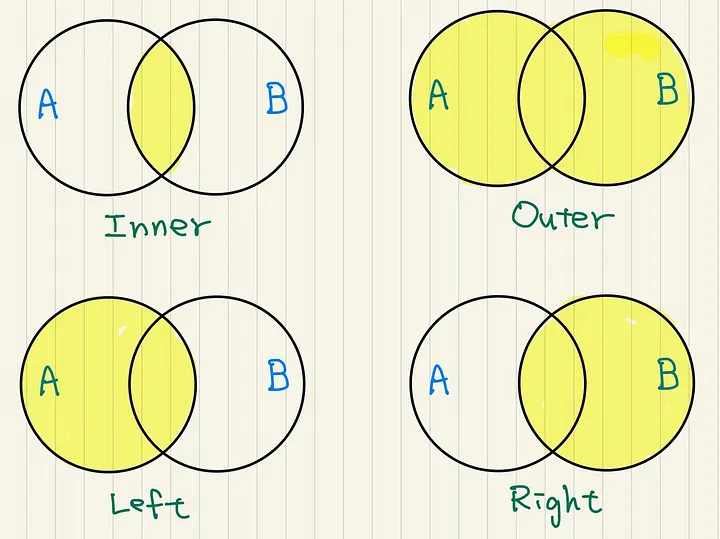

#### 資料視覺化

<Axes: xlabel='classk', ylabel='count'>

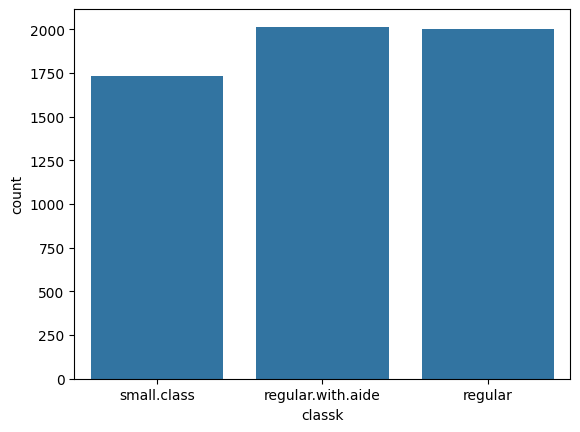

In [ ]:
# 長條圖 / 計數圖：每一種課程類型(classk)的計數
sns.countplot(x='classk', data=star_df)

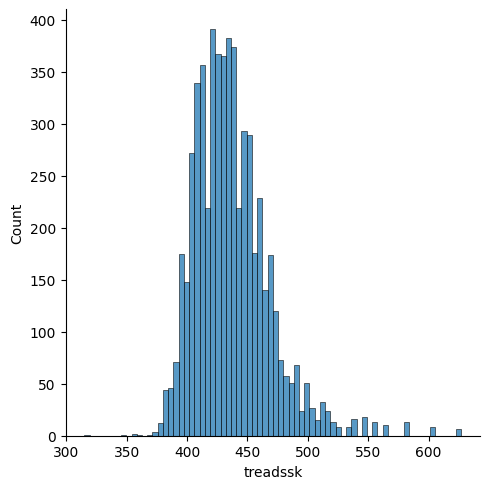

In [ ]:
# 直方圖來顯示閱讀分數的分佈
sns.displot(x='treadssk', data=star_df)

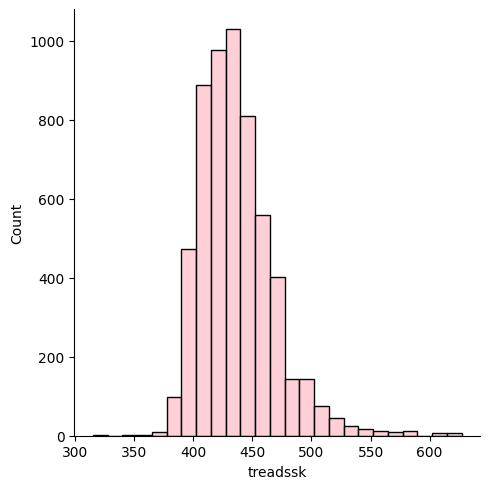

In [ ]:
# 自定義直方圖
sns.displot(x='treadssk', data=star_df, bins=25, color='pink')

<Axes: xlabel='treadssk'>

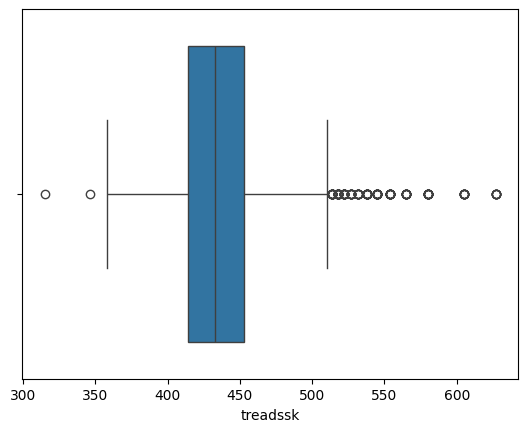

In [ ]:
#箱形圖
sns.boxplot(x='treadssk', data=star_df)

<Axes: ylabel='treadssk'>

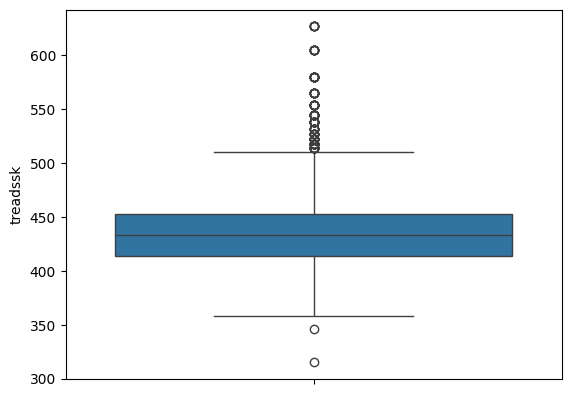

In [ ]:
#翻轉的箱形圖
sns.boxplot(y='treadssk', data=star_df)

<Axes: xlabel='classk', ylabel='treadssk'>

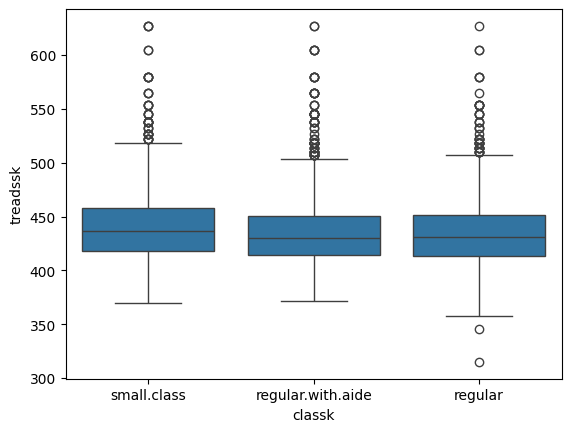

In [ ]:
#每一種課程類型(classk)的閱讀分數的箱形圖
sns.boxplot(x='classk', y='treadssk', data=star_df)

<Axes: xlabel='tmathssk', ylabel='treadssk'>

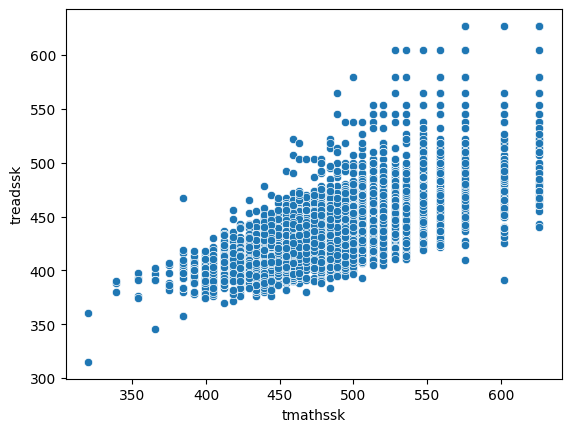

In [ ]:
#數學分數和閱讀分數的散布圖來呈現兩者的關係
sns.scatterplot(x='tmathssk', y='treadssk', data=star_df)

Text(0.5, 1.0, 'Math score vs. Reading score')

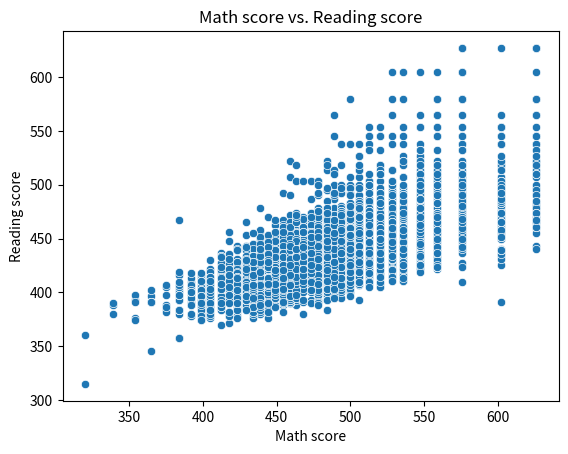

In [ ]:
#數學分數和閱讀分數的散布圖來呈現兩者的關係
sns.scatterplot(x='tmathssk', y='treadssk', data=star_df)
plt.xlabel('Math score')
plt.ylabel('Reading score')
plt.title('Math score vs. Reading score')

In [ ]:
# Load 中文字型
import matplotlib
from matplotlib.font_manager import fontManager
target_font_path = Path.cwd() / 'drive' / 'MyDrive' / '資料分析案例實作' / 'star' / 'NotoSansTC-Regular.ttf'
fontManager.addfont(target_font_path)
matplotlib.rc('font',family = 'Noto Sans TC')

Text(0.5, 1.0, '數學分數 vs. 閱讀分數')

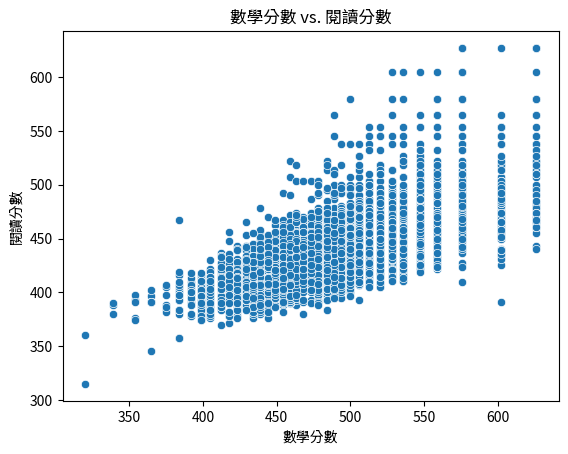

In [ ]:
#顯示繁體中文
sns.scatterplot(x='tmathssk', y='treadssk', data=star_df)
plt.xlabel('數學分數')
plt.ylabel('閱讀分數')
plt.title('數學分數 vs. 閱讀分數')